# How Big Is This Cluster?

We know the cluster has 2,212 tokens that compress to 125 unique vectors. But how spread out are they in space?

Let's measure:
- **Diameter**: The maximum distance between any two cluster tokens
- **Radius**: The maximum distance from the cluster's center
- **Centroids**: Both geometric (mean of unique vectors) and mass-weighted (mean of all tokens)

This will tell us the physical extent of this weird structure.

## Parameters

In [1]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Output
OUTPUT_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.11b_cluster_extent.safetensors'

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [5]:
# Load gamma matrix
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.float32).to(device)

print(f"Loaded gamma matrix: {W.shape}")

Loaded gamma matrix: torch.Size([151936, 2560])


In [6]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors

In [7]:
# Find unique vectors (need this for geometric centroid)
unique_vectors = torch.unique(cluster_vectors.to('cpu'), dim=0).to(device)

print(f"Found {len(unique_vectors)} unique vectors")

Found 125 unique vectors


## Compute Centroids

Two different notions of "center":
- **Geometric centroid**: Mean of the 125 unique vectors (treats each vector equally)
- **Center of mass**: Mean of all 2,212 tokens (weights by population)

In [8]:
# Geometric centroid: mean of unique vectors
centroid_geometric = torch.mean(unique_vectors, dim=0)
centroid_geometric_norm = torch.norm(centroid_geometric).item()

print(f"Geometric centroid:")
print(f"  L2 norm from origin: {centroid_geometric_norm:.6f}")

Geometric centroid:
  L2 norm from origin: 0.370917


In [9]:
# Center of mass: mean of all tokens (weighted by population)
centroid_mass = torch.mean(cluster_vectors, dim=0)
centroid_mass_norm = torch.norm(centroid_mass).item()

print(f"Center of mass:")
print(f"  L2 norm from origin: {centroid_mass_norm:.6f}")

Center of mass:
  L2 norm from origin: 0.370917


In [10]:
# Distance between the two centroids
centroid_separation = torch.norm(centroid_geometric - centroid_mass).item()

print(f"\nSeparation between centroids: {centroid_separation:.6e}")
print(f"  (as fraction of origin distance: {centroid_separation / centroid_mass_norm:.6f})")


Separation between centroids: 1.971483e-05
  (as fraction of origin distance: 0.000053)


## Measure the Radius

How far is the most distant token from the center of mass?

In [11]:
# Compute distances from center of mass
distances_from_centroid = torch.norm(cluster_vectors - centroid_mass, dim=1)

# Statistics
min_radius = torch.min(distances_from_centroid).item()
max_radius = torch.max(distances_from_centroid).item()
mean_radius = torch.mean(distances_from_centroid).item()
median_radius = torch.median(distances_from_centroid).item()

print(f"Distances from center of mass:")
print(f"  Min: {min_radius:.6e}")
print(f"  Max (radius): {max_radius:.6e}")
print(f"  Mean: {mean_radius:.6e}")
print(f"  Median: {median_radius:.6e}")

Distances from center of mass:
  Min: 1.667259e-05
  Max (radius): 1.038779e-03
  Mean: 2.331665e-05
  Median: 1.798117e-05


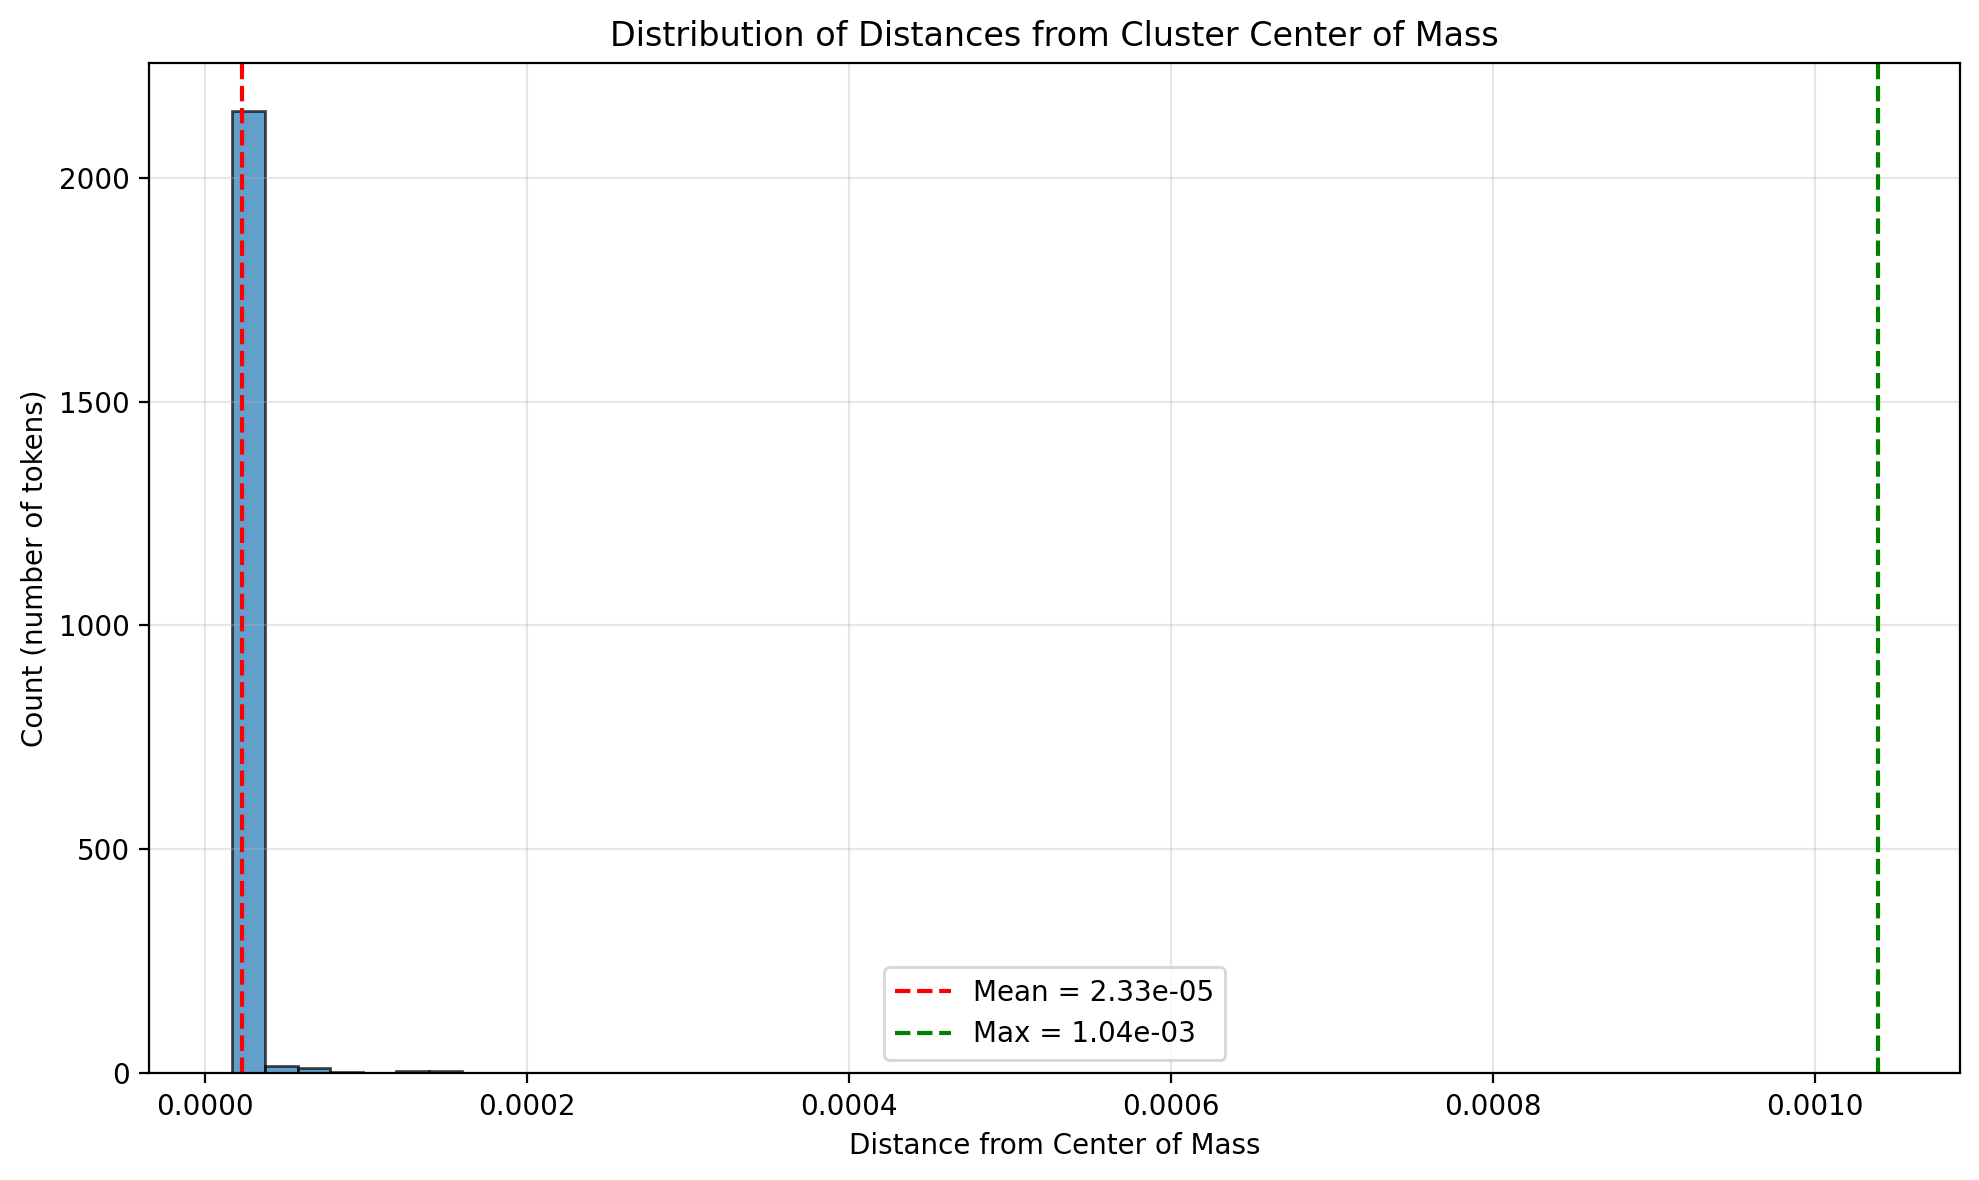


The cluster fits in a sphere of radius 1.038779e-03


In [12]:
# Visualize distribution of distances from center of mass
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

distances_cpu = distances_from_centroid.cpu().numpy()
ax.hist(distances_cpu, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(mean_radius, color='r', linestyle='--', label=f'Mean = {mean_radius:.2e}')
ax.axvline(max_radius, color='g', linestyle='--', label=f'Max = {max_radius:.2e}')

ax.set_xlabel('Distance from Center of Mass')
ax.set_ylabel('Count (number of tokens)')
ax.set_title('Distribution of Distances from Cluster Center of Mass')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe cluster fits in a sphere of radius {max_radius:.6e}")

## Measure the Diameter

What's the maximum distance between any two cluster tokens?

This is expensive (2,212 choose 2 = 2.4M pairs), so we'll compute it carefully.

In [13]:
print(f"Computing pairwise distances for {len(cluster_vectors)} vectors...")
print(f"Number of pairs: {len(cluster_vectors) * (len(cluster_vectors) - 1) // 2:,}")

# Compute all pairwise L2 distances
with torch.no_grad():
    pairwise_distances = torch.cdist(cluster_vectors, cluster_vectors, p=2)

print(f"Computed {pairwise_distances.shape[0]} x {pairwise_distances.shape[1]} distance matrix")

Computing pairwise distances for 2212 vectors...
Number of pairs: 2,445,366
Computed 2212 x 2212 distance matrix


In [14]:
# Find maximum distance (diameter)
diameter = torch.max(pairwise_distances).item()

# Find which pair of tokens are maximally separated
max_indices = torch.where(pairwise_distances == diameter)
token_i = cluster_token_ids[max_indices[0][0]].item()
token_j = cluster_token_ids[max_indices[1][0]].item()

print(f"Cluster diameter: {diameter:.6e}")
print(f"Most distant pair: tokens {token_i} and {token_j}")
print(f"\nDiameter / Radius ratio: {diameter / max_radius:.2f}")

Cluster diameter: 1.859320e-03
Most distant pair: tokens 136461 and 141553

Diameter / Radius ratio: 1.79


## Distribution of All Pairwise Distances

In [15]:
# Extract upper triangle (excluding diagonal) to avoid double-counting
triu_indices = torch.triu_indices(len(cluster_vectors), len(cluster_vectors), offset=1)
distances_flat = pairwise_distances[triu_indices[0], triu_indices[1]].cpu().numpy()

print(f"Pairwise distance statistics ({len(distances_flat):,} pairs):")
print(f"  Min: {np.min(distances_flat):.6e}")
print(f"  Max (diameter): {np.max(distances_flat):.6e}")
print(f"  Mean: {np.mean(distances_flat):.6e}")
print(f"  Median: {np.median(distances_flat):.6e}")

Pairwise distance statistics (2,445,366 pairs):
  Min: 2.729575e-04
  Max (diameter): 1.859320e-03
  Mean: 8.788811e-04
  Median: 8.802615e-04


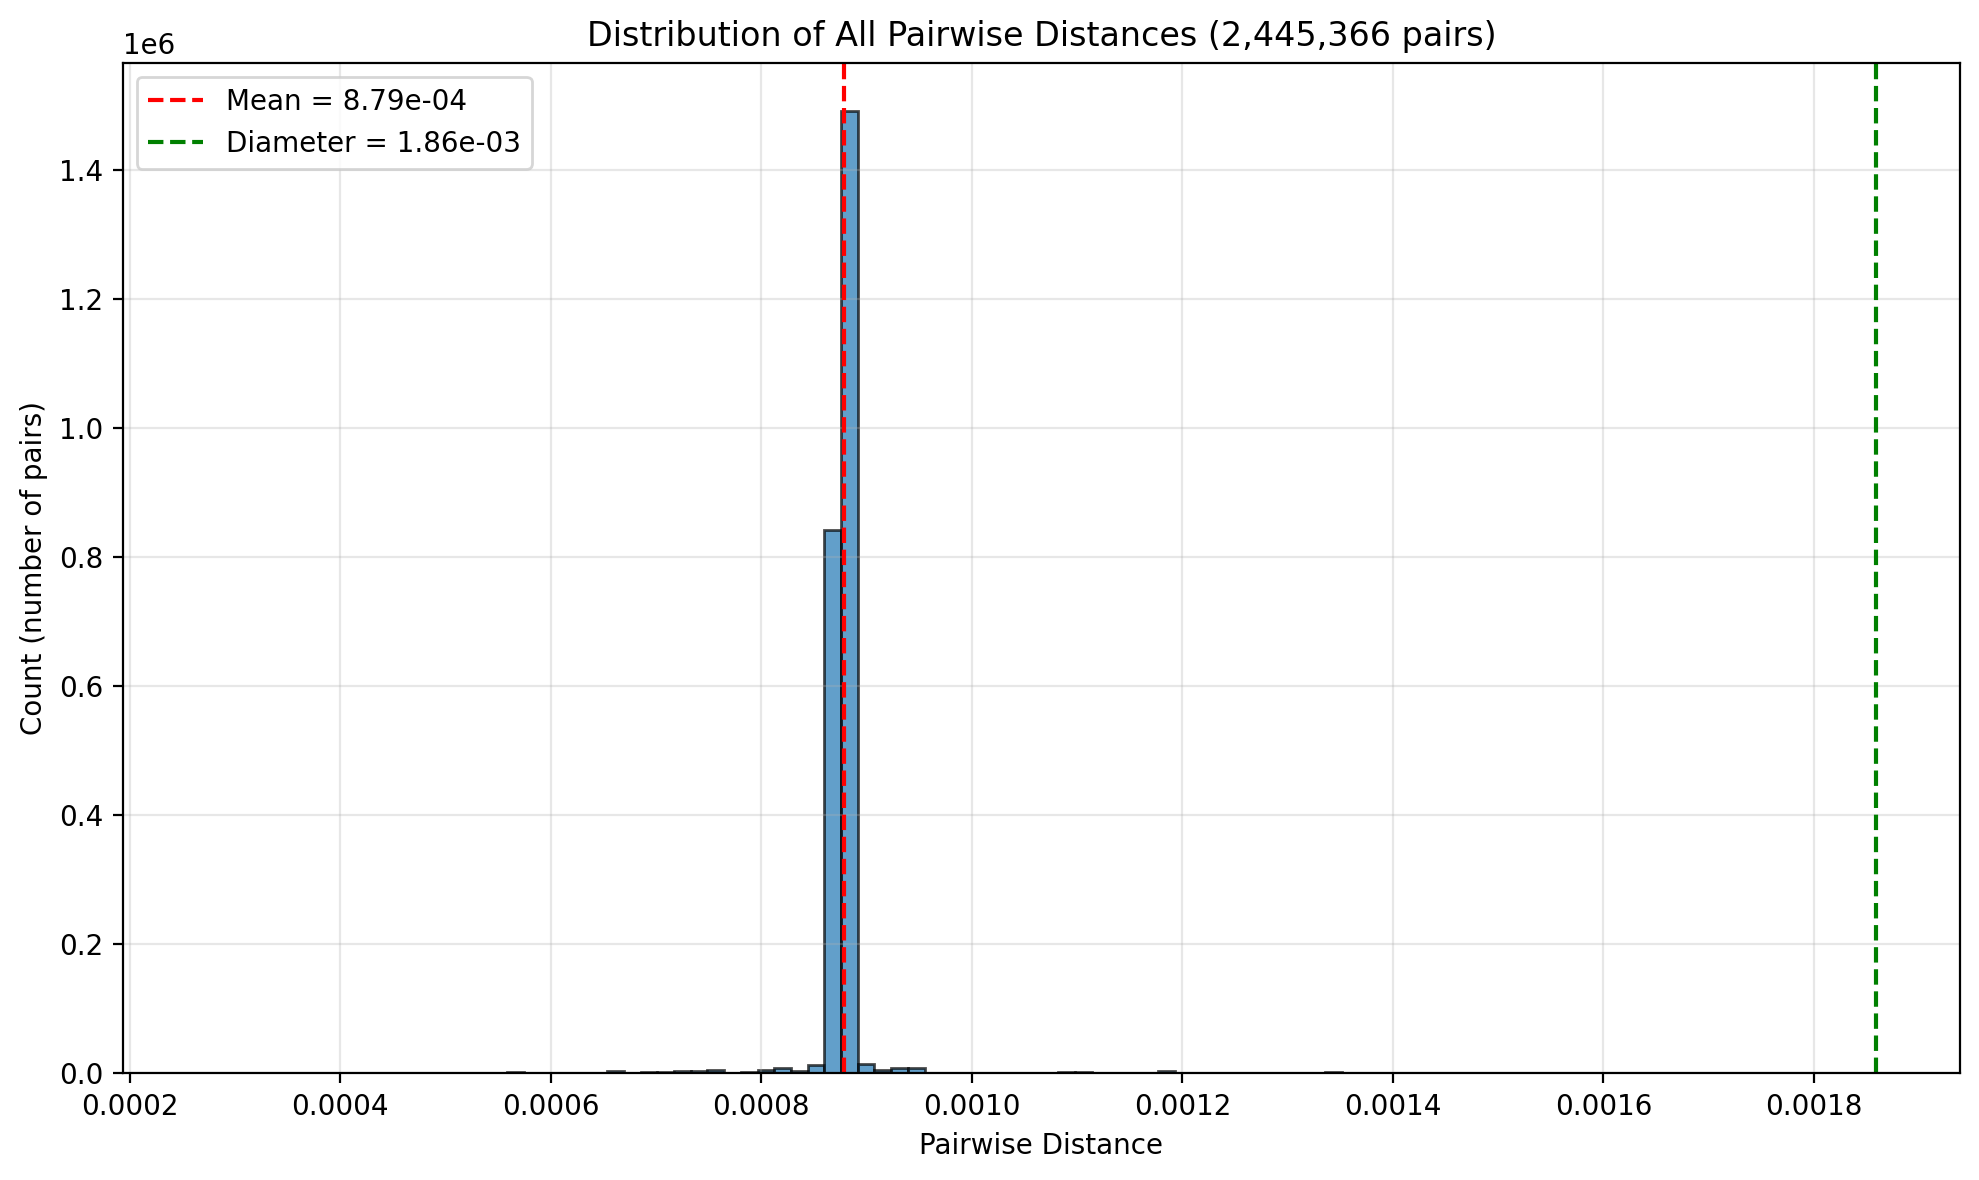

In [16]:
# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.hist(distances_flat, bins=100, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(distances_flat), color='r', linestyle='--', 
           label=f'Mean = {np.mean(distances_flat):.2e}')
ax.axvline(diameter, color='g', linestyle='--', 
           label=f'Diameter = {diameter:.2e}')

ax.set_xlabel('Pairwise Distance')
ax.set_ylabel('Count (number of pairs)')
ax.set_title(f'Distribution of All Pairwise Distances ({len(distances_flat):,} pairs)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Estimate Gaussian σ

If these tokens were sampled from a Gaussian centered at the center of mass, what would σ be?

For a spherical Gaussian in D dimensions, the expected distance from the center is approximately √D × σ.
But we can also estimate σ directly from the observed spread.

In [17]:
# Method 1: From mean distance to center of mass
# In high dimensions, mean distance ≈ sqrt(D) * σ
D = cluster_vectors.shape[1]
sigma_from_mean = mean_radius / np.sqrt(D)

# Method 2: From std of component values
# Directly measure the spread in each dimension
component_std = torch.std(cluster_vectors, dim=0).mean().item()

# Method 3: From diameter (diameter ≈ 6σ for ~99.7% of points)
sigma_from_diameter = diameter / 6

print(f"Gaussian σ estimates:")
print(f"  From mean radius: {sigma_from_mean:.6e}")
print(f"  From component std: {component_std:.6e}")
print(f"  From diameter (÷6): {sigma_from_diameter:.6e}")
print(f"\nBest estimate (component std): {component_std:.6e}")

Gaussian σ estimates:
  From mean radius: 4.608357e-07
  From component std: 9.767548e-07
  From diameter (÷6): 3.098866e-04

Best estimate (component std): 9.767548e-07


## Save Results

In [18]:
# Save key measurements
save_file(
    {
        'centroid_geometric': centroid_geometric.cpu(),
        'centroid_mass': centroid_mass.cpu(),
        'centroid_geometric_norm': torch.tensor([centroid_geometric_norm]),
        'centroid_mass_norm': torch.tensor([centroid_mass_norm]),
        'centroid_separation': torch.tensor([centroid_separation]),
        'radius': torch.tensor([max_radius]),
        'diameter': torch.tensor([diameter]),
        'mean_radius': torch.tensor([mean_radius]),
        'sigma_estimate': torch.tensor([component_std]),
        'cluster_token_ids': cluster_token_ids.cpu(),
    },
    OUTPUT_PATH
)

print(f"Saved cluster extent measurements to {OUTPUT_PATH}")

Saved cluster extent measurements to ../tensors/Qwen3-4B-Instruct-2507/1.11b_cluster_extent.safetensors


## Summary

In [19]:
print("="*60)
print("CLUSTER EXTENT SUMMARY")
print("="*60)
print(f"Number of tokens: {len(cluster_vectors)}")
print(f"Number of unique vectors: {len(unique_vectors)}")
print(f"Dimensionality: {D}")
print(f"\nCentroids:")
print(f"  Geometric centroid norm: {centroid_geometric_norm:.6f}")
print(f"  Center of mass norm: {centroid_mass_norm:.6f}")
print(f"  Separation: {centroid_separation:.6e}")
print(f"\nSize (measured from center of mass):")
print(f"  Radius: {max_radius:.6e}")
print(f"  Diameter: {diameter:.6e}")
print(f"  Mean distance from center: {mean_radius:.6e}")
print(f"\nEstimated σ (if Gaussian): {component_std:.6e}")
print(f"\nScale comparison:")
print(f"  Diameter / Center of mass norm: {diameter / centroid_mass_norm:.6e}")
print(f"  Radius / Center of mass norm: {max_radius / centroid_mass_norm:.6e}")
print("="*60)

CLUSTER EXTENT SUMMARY
Number of tokens: 2212
Number of unique vectors: 125
Dimensionality: 2560

Centroids:
  Geometric centroid norm: 0.370917
  Center of mass norm: 0.370917
  Separation: 1.971483e-05

Size (measured from center of mass):
  Radius: 1.038779e-03
  Diameter: 1.859320e-03
  Mean distance from center: 2.331665e-05

Estimated σ (if Gaussian): 9.767548e-07

Scale comparison:
  Diameter / Center of mass norm: 5.012762e-03
  Radius / Center of mass norm: 2.800569e-03
